🚀 运行设备: cuda

>>> [1/8] 准备数据 (Hash互斥划分)...

>>> [2/8] 绘制数据集分布饼图...


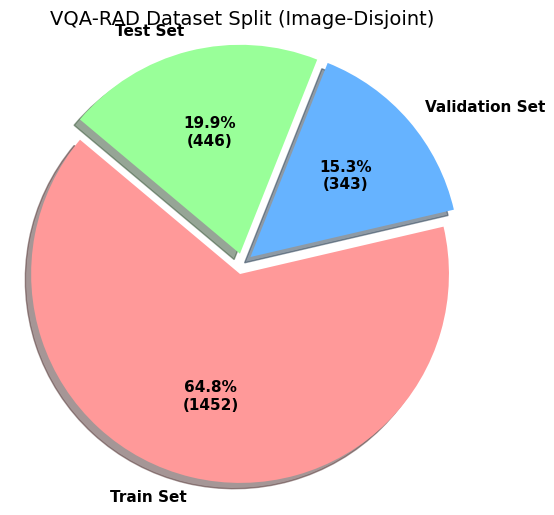


>>> [3/8] 构建词表与增强策略...

>>> [4/8] 开始训练 (抗过拟合模式)...
Epoch 01 | Train: 4.0943 | Val: 2.4186 | Val Acc: 42.34%
         -> 🌟 New Best Model Saved!
Epoch 02 | Train: 2.9677 | Val: 2.1337 | Val Acc: 40.32%
         -> 🌟 New Best Model Saved!
Epoch 03 | Train: 2.6715 | Val: 2.0532 | Val Acc: 49.19%
         -> 🌟 New Best Model Saved!
Epoch 04 | Train: 2.3930 | Val: 1.9950 | Val Acc: 47.58%
         -> 🌟 New Best Model Saved!
Epoch 05 | Train: 2.1856 | Val: 1.9402 | Val Acc: 47.98%
         -> 🌟 New Best Model Saved!
Epoch 06 | Train: 1.9321 | Val: 1.9572 | Val Acc: 46.77%
Epoch 07 | Train: 1.7014 | Val: 1.9253 | Val Acc: 46.37%
         -> 🌟 New Best Model Saved!
Epoch 08 | Train: 1.4708 | Val: 1.9339 | Val Acc: 46.37%
Epoch 09 | Train: 1.2462 | Val: 1.9235 | Val Acc: 51.21%
         -> 🌟 New Best Model Saved!
Epoch 10 | Train: 1.0782 | Val: 2.0383 | Val Acc: 52.42%
Epoch 11 | Train: 0.9248 | Val: 2.0175 | Val Acc: 51.61%
Epoch 12 | Train: 0.7244 | Val: 2.0010 | Val Acc: 53.63%
Epoch 13 | T

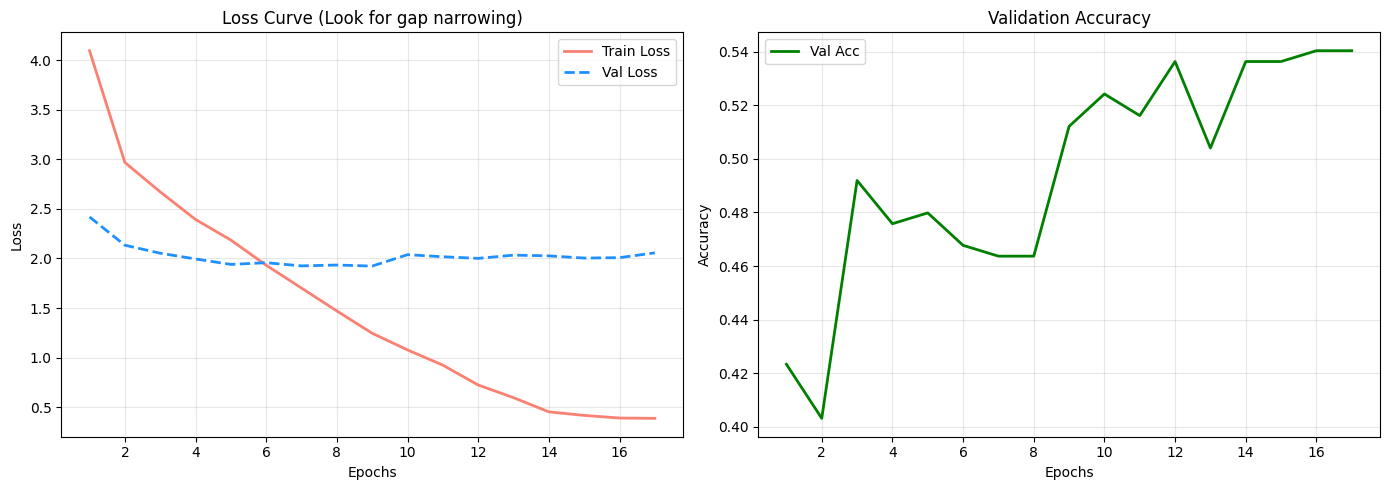


>>> [6/8] 最终测试集评估...

🏆 TEST RESULTS:
Overall Acc: 60.25%
F1 Score:    0.5931
Closed Acc:  66.14%
Open Acc:    39.44%

>>> [7/8] 随机抽取 6 个测试样本可视化...


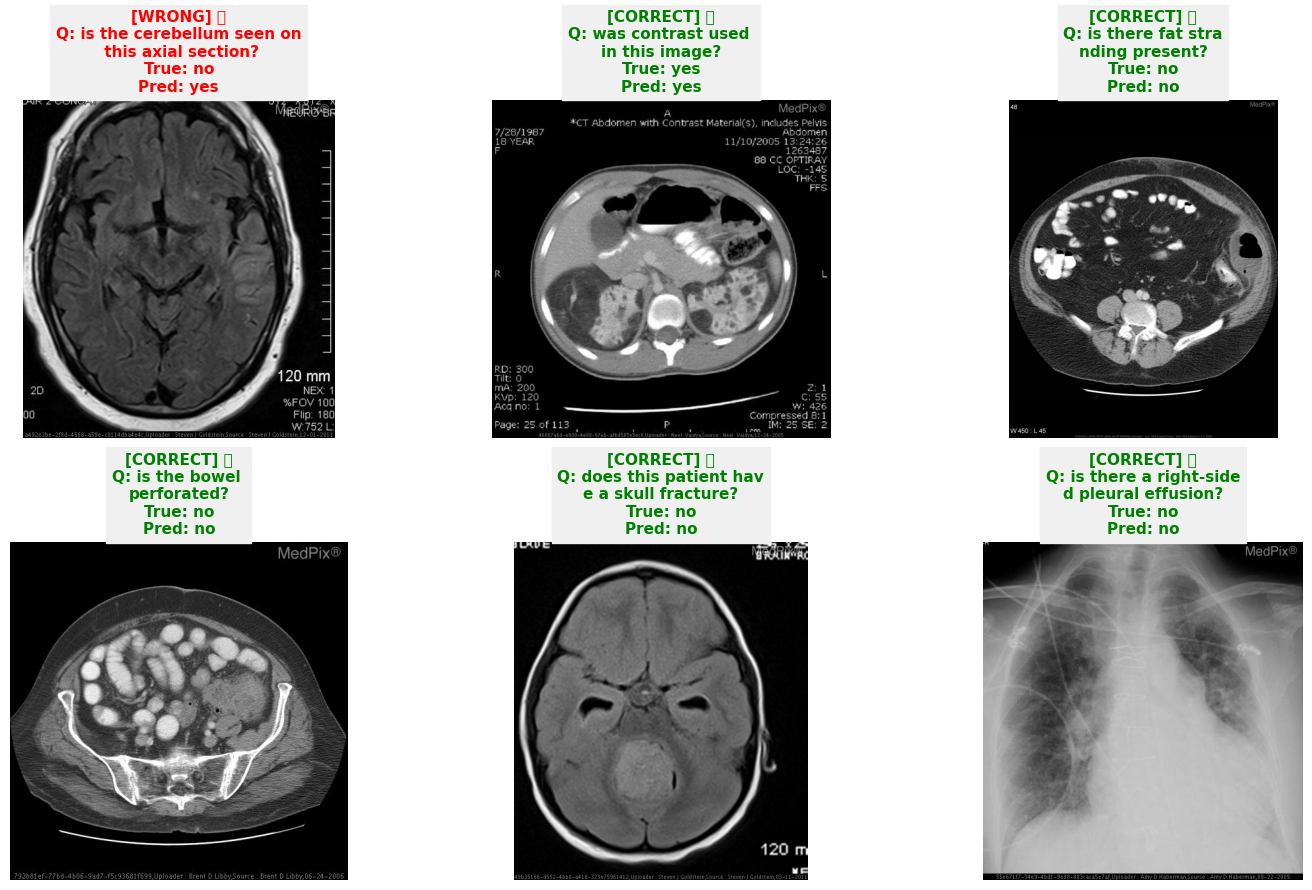


>>> [8/8] 全部执行完毕！


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from datasets import load_dataset
from collections import Counter, defaultdict
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import hashlib
import warnings

warnings.filterwarnings("ignore")

# ================= 1. 全局配置 =================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 运行设备: {DEVICE}")

# 🔥 抗过拟合超参数配置
BATCH_SIZE = 32
EPOCHS = 40
LEARNING_RATE = 5e-4    # 稍微降低学习率
WEIGHT_DECAY = 1e-4     # 强正则化
MAX_SEQ_LEN = 20
VOCAB_SIZE = 3000
PATIENCE = 8
OUTPUT_DIR = "./output_final_robust"

if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)
BEST_MODEL_PATH = os.path.join(OUTPUT_DIR, 'best_medvqa_robust.pth')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# ================= 2. 数据处理 (Image-Disjoint) =================
print("\n>>> [1/8] 准备数据 (Hash互斥划分)...")
dataset_raw = load_dataset("flaviagiammarino/vqa-rad")
full_list = list(dataset_raw['train']) + list(dataset_raw['test'])

def get_image_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

def group_and_split_dataset(raw_data_list):
    image_to_qa = defaultdict(list)
    for item in raw_data_list:
        img_id = get_image_hash(item['image'])
        image_to_qa[img_id].append(item)
    
    unique_ids = list(image_to_qa.keys())
    random.shuffle(unique_ids) 
    
    # 20% Test, 15% Val
    test_cutoff = int(len(unique_ids) * 0.2)
    val_cutoff = int(len(unique_ids) * 0.15)
    
    test_ids = unique_ids[:test_cutoff]
    val_ids = unique_ids[test_cutoff : test_cutoff+val_cutoff]
    train_ids = unique_ids[test_cutoff+val_cutoff:]

    def flatten(ids):
        data = []
        for i in ids: data.extend(image_to_qa[i])
        random.shuffle(data)
        return data

    return flatten(train_ids), flatten(val_ids), flatten(test_ids)

train_list, val_list, test_list = group_and_split_dataset(full_list)

# ================= 3. 🔥 新增: 绘制数据集划分饼图 =================
print("\n>>> [2/8] 绘制数据集分布饼图...")

def plot_data_distribution(train, val, test):
    labels = ['Train Set', 'Validation Set', 'Test Set']
    sizes = [len(train), len(val), len(test)]
    colors = ['#ff9999', '#66b3ff', '#99ff99'] 
    explode = (0.05, 0.05, 0.05) 

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, explode=explode, 
            autopct=lambda p: '{:.1f}%\n({:d})'.format(p, int(p/100.*sum(sizes))), 
            shadow=True, startangle=140, textprops={'fontsize': 11, 'weight': 'bold'})
    plt.title('VQA-RAD Dataset Split (Image-Disjoint)', fontsize=14)
    plt.axis('equal')
    plt.show()

plot_data_distribution(train_list, val_list, test_list)

# ================= 4. 词表与增强 =================
print("\n>>> [3/8] 构建词表与增强策略...")
def build_vocab(data):
    words = []
    for item in data: words.extend(item['question'].lower().replace("?", "").split())
    count = Counter(words)
    vocab = {w: i+2 for i, (w, c) in enumerate(count.most_common(VOCAB_SIZE))}
    vocab["<PAD>"] = 0; vocab["<UNK>"] = 1
    
    answers = [str(item['answer']).lower() for item in data]
    ans_vocab = {ans: i for i, (ans, c) in enumerate(Counter(answers).most_common(450))}
    return vocab, ans_vocab

q_vocab, ans_vocab = build_vocab(train_list)
id2answer = {v: k for k, v in ans_vocab.items()}
NUM_CLASSES = len(ans_vocab)

# 🔥 强增强策略 (抗过拟合)
train_tfm = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.RandomRotation(30),          # 增大旋转
    transforms.RandomAffine(                # 新增仿射变换
        degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)
    ),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_tfm = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class VQADataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data; self.transform = transform
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image'].convert('RGB')
        q_text = item['question'].lower().replace("?", "").split()
        ans_text = str(item['answer']).lower()
        if self.transform: image = self.transform(image)
        q_ids = [q_vocab.get(w, 1) for w in q_text][:MAX_SEQ_LEN]
        q_ids += [0] * (MAX_SEQ_LEN - len(q_ids))
        label = ans_vocab.get(ans_text, -1)
        type_flag = 1 if ans_text in ['yes', 'no'] else 0 
        return image, torch.tensor(q_ids), torch.tensor(label), type_flag

train_loader = DataLoader(VQADataset(train_list, train_tfm), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(VQADataset(val_list, test_tfm), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(VQADataset(test_list, test_tfm), batch_size=BATCH_SIZE, shuffle=False)

# ================= 5. 模型定义 (瘦身版) =================
class MedVQAModel(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        for p in resnet.parameters(): p.requires_grad = False
        self.img_enc = nn.Sequential(*list(resnet.children())[:-1])
        
        # 🔥 瘦身: 2048 -> 256
        self.img_fc = nn.Linear(2048, 256) 
        
        self.emb = nn.Embedding(len(q_vocab)+2, 300)
        # 🔥 瘦身: LSTM hidden 512 -> 256
        self.lstm = nn.LSTM(300, 256, batch_first=True, num_layers=2, bidirectional=True, dropout=0.3)
        
        # 🔥 瘦身: Classifier Input 768
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),         
            nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, NUM_CLASSES)
        )
        
    def forward(self, img, q):
        with torch.no_grad():
            img_f = self.img_enc(img).flatten(1)
        img_f = self.img_fc(img_f)
        _, (h, _) = self.lstm(self.emb(q))
        text_f = torch.cat((h[-2], h[-1]), dim=1)
        return self.classifier(torch.cat((img_f, text_f), dim=1))

# ================= 6. 训练循环 (带 Weight Decay) =================
print("\n>>> [4/8] 开始训练 (抗过拟合模式)...")
model = MedVQAModel().to(DEVICE)
criterion = nn.CrossEntropyLoss()

# 🔥 关键: Weight Decay 加入
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
best_loss = float('inf')
patience_counter = 0

start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for img, q, label, _ in train_loader:
        img, q, label = img.to(DEVICE), q.to(DEVICE), label.to(DEVICE)
        valid = label != -1
        if not valid.any(): continue
        
        optimizer.zero_grad()
        out = model(img[valid], q[valid])
        loss = criterion(out, label[valid])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    # Validation
    model.eval()
    val_loss = 0; correct = 0; total = 0
    with torch.no_grad():
        for img, q, label, _ in val_loader:
            img, q, label = img.to(DEVICE), q.to(DEVICE), label.to(DEVICE)
            valid = label != -1
            if not valid.any(): continue
            out = model(img[valid], q[valid])
            val_loss += criterion(out, label[valid]).item()
            correct += (out.argmax(1) == label[valid]).sum().item()
            total += valid.sum().item()
            
    avg_train = train_loss / len(train_loader)
    avg_val = val_loss / len(val_loader) if len(val_loader) > 0 else 0
    val_acc = correct / total if total > 0 else 0
    
    history['train_loss'].append(avg_train)
    history['val_loss'].append(avg_val)
    history['val_acc'].append(val_acc)
    
    scheduler.step(avg_val)
    print(f"Epoch {epoch+1:02d} | Train: {avg_train:.4f} | Val: {avg_val:.4f} | Val Acc: {val_acc:.2%}")
    
    if avg_val < best_loss:
        best_loss = avg_val
        patience_counter = 0
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print("         -> 🌟 New Best Model Saved!")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("🛑 Early Stopping!"); break

print(f"✅ 训练结束，耗时 {(time.time()-start_time)/60:.1f} 分钟")

# ================= 7. 绘制训练曲线 =================
print("\n>>> [5/8] 绘制训练曲线...")
def plot_history(hist):
    epochs = range(1, len(hist['train_loss']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    ax1.plot(epochs, hist['train_loss'], label='Train Loss', color='salmon', linewidth=2)
    ax1.plot(epochs, hist['val_loss'], label='Val Loss', color='dodgerblue', linestyle='--', linewidth=2)
    ax1.set_title('Loss Curve (Look for gap narrowing)')
    ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss')
    ax1.legend(); ax1.grid(True, alpha=0.3)
    
    # Accuracy
    ax2.plot(epochs, hist['val_acc'], label='Val Acc', color='green', linewidth=2)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs'); ax2.set_ylabel('Accuracy')
    ax2.legend(); ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_history(history)

# ================= 8. 最终测试 =================
print("\n>>> [6/8] 最终测试集评估...")
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()
preds, labels, types = [], [], []

with torch.no_grad():
    for img, q, label, type_ in test_loader:
        img, q, label = img.to(DEVICE), q.to(DEVICE), label.to(DEVICE)
        valid = label != -1
        if not valid.any(): continue
        
        out = model(img[valid], q[valid])
        preds.extend(out.argmax(1).cpu().numpy())
        labels.extend(label[valid].cpu().numpy())
        types.extend(type_[valid.cpu()].numpy())

preds = np.array(preds); labels = np.array(labels); types = np.array(types)
acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average='weighted', zero_division=0)
closed_mask = (types == 1)

print(f"\n🏆 TEST RESULTS:")
print(f"Overall Acc: {acc:.2%}")
print(f"F1 Score:    {f1:.4f}")
print(f"Closed Acc:  {accuracy_score(labels[closed_mask], preds[closed_mask]):.2%}")
print(f"Open Acc:    {accuracy_score(labels[~closed_mask], preds[~closed_mask]):.2%}")

# ================= 9. 随机样本可视化 =================
print("\n>>> [7/8] 随机抽取 6 个测试样本可视化...")

random.seed(time.time())

def visualize_test_samples(dataset, model, num_samples=6):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    
    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(15, 9))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        item = dataset[idx]
        raw_image = item['image'].convert('RGB')
        question = item['question']
        true_ans = str(item['answer']).lower()
        
        img_tensor = test_tfm(raw_image).unsqueeze(0).to(DEVICE)
        q_tokens = question.lower().replace("?", "").split()
        q_ids = [q_vocab.get(w, 1) for w in q_tokens][:MAX_SEQ_LEN]
        q_ids += [0] * (MAX_SEQ_LEN - len(q_ids))
        q_tensor = torch.tensor([q_ids]).to(DEVICE)
        
        with torch.no_grad():
            out = model(img_tensor, q_tensor)
            pred_idx = torch.argmax(out, dim=1).item()
            pred_ans = id2answer.get(pred_idx, "<unk>")
        
        ax = axes[i]
        ax.imshow(raw_image)
        ax.axis('off')
        
        if pred_ans == true_ans:
            color = 'green'; tag = "[CORRECT] ✅"
        else:
            color = 'red'; tag = "[WRONG] ❌"
        
        title = f"{tag}\nQ: {question}\nTrue: {true_ans}\nPred: {pred_ans}"
        if len(title) > 50:
            mid = len(title) // 2
            title = title[:mid] + "\n" + title[mid:]
            
        ax.set_title(title, fontsize=11, color=color, fontweight='bold', backgroundcolor='#f0f0f0')

    plt.tight_layout()
    plt.show()

visualize_test_samples(test_list, model)
print("\n>>> [8/8] 全部执行完毕！")


>>> [7/8] 随机抽取 6 个测试样本可视化...


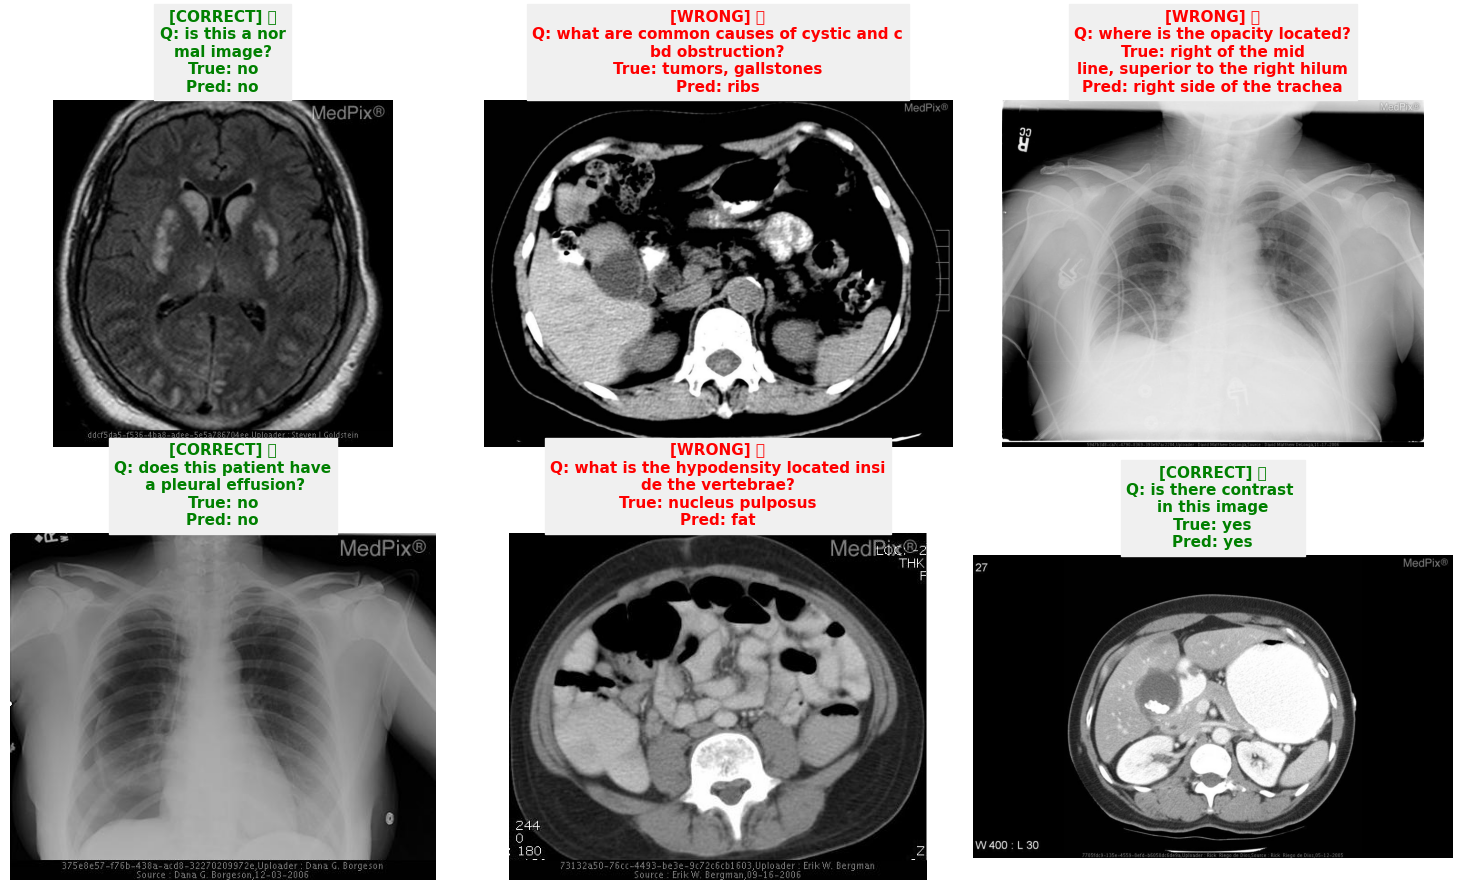


>>> [8/8] 全部执行完毕！


In [10]:
print("\n>>> [7/8] 随机抽取 6 个测试样本可视化...")

def visualize_test_samples(dataset, model, num_samples=6):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    
    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(15, 9))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        item = dataset[idx]
        raw_image = item['image'].convert('RGB')
        question = item['question']
        true_ans = str(item['answer']).lower()
        
        img_tensor = test_tfm(raw_image).unsqueeze(0).to(DEVICE)
        q_tokens = question.lower().replace("?", "").split()
        q_ids = [q_vocab.get(w, 1) for w in q_tokens][:MAX_SEQ_LEN]
        q_ids += [0] * (MAX_SEQ_LEN - len(q_ids))
        q_tensor = torch.tensor([q_ids]).to(DEVICE)
        
        with torch.no_grad():
            out = model(img_tensor, q_tensor)
            pred_idx = torch.argmax(out, dim=1).item()
            pred_ans = id2answer.get(pred_idx, "<unk>")
                    
        ax = axes[i]
        ax.imshow(raw_image)
        ax.axis('off')
        
        if pred_ans == true_ans:
            color = 'green'; tag = "[CORRECT] ✅"
        else:
            color = 'red'; tag = "[WRONG] ❌"
        
        title = f"{tag}\nQ: {question}\nTrue: {true_ans}\nPred: {pred_ans}"
        if len(title) > 50:
            mid = len(title) // 2
            title = title[:mid] + "\n" + title[mid:]
            
        ax.set_title(title, fontsize=11, color=color, fontweight='bold', backgroundcolor='#f0f0f0')

    plt.tight_layout()
    plt.show()

visualize_test_samples(test_list, model)
print("\n>>> [8/8] 全部执行完毕！")